# Предсказание стоимости жилья

Целью проекта является обучение модели линейной регрессии на данных о жилье в Калифорнии в 1990 году, предсказывающей медианную стоимость дома в жилом массиве.

Данные собраны в рамках переписи населения в США. Каждая строка содержит агрегированную статистику о жилом массиве - минимальной географической единице с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

В соответствие с условием проекта для обучения модели будет использован фреймворк Spark, для оценки качества модели используются метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

Вcе колонки, за исключением одной, содержат количественные значения, столбец `ocean_proximity` - категориальные.

## Подготовка данных

### Общее изучение данных

Импортируем необходимые библиотеки

In [884]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [885]:
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2023

Инициализируем Spark-сессию.

In [886]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

Читаем содержимое файла /datasets/housing.csv.

In [887]:
df_housing = spark.read.load('/datasets/housing.csv',
                             format="csv", sep=",", inferSchema=True, header="true")
df_housing.printSchema() 

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Выводим типы данных колонок датасета.

In [888]:
spark.createDataFrame(df_housing.dtypes,['column', 'type']).show()

+------------------+------+
|            column|  type|
+------------------+------+
|         longitude|double|
|          latitude|double|
|housing_median_age|double|
|       total_rooms|double|
|    total_bedrooms|double|
|        population|double|
|        households|double|
|     median_income|double|
|median_house_value|double|
|   ocean_proximity|string|
+------------------+------+



Выведем базовые описательные статистики данных в Spark.

In [889]:
df_housing.select('longitude','latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms').describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403115|
|    min|            -124.35|            32.54|               1.0|               2.0|               1.0|
|    max|            -114.31|            41.95|              52.0|           39320.0|            6445.0|
+-------+-------------------+-----------------+------------------+------------------+------------------+



In [890]:
df_housing.select('population','households', 'median_income', 'median_house_value', 'ocean_proximity').describe().show()

+-------+------------------+-----------------+------------------+------------------+---------------+
|summary|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+------------------+-----------------+------------------+------------------+---------------+
|  count|             20640|            20640|             20640|             20640|          20640|
|   mean|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           null|
| stddev|  1132.46212176534|382.3297528316098| 1.899821717945263|115395.61587441359|           null|
|    min|               3.0|              1.0|            0.4999|           14999.0|      <1H OCEAN|
|    max|           35682.0|           6082.0|           15.0001|          500001.0|     NEAR OCEAN|
+-------+------------------+-----------------+------------------+------------------+---------------+



Циклом, примененным ко всем столбцам датафрейма, методами isNull и isnan установим наличие пропусков, функциями filter() и count() найдем их сумму по каждому столбцу. Также в теле цикла все данные приведем к единому типу 'string'. 

In [892]:
columns = df_housing.columns

for column in columns:
    c = F.col(column).cast('string') 
    check_null = c.isNull() 
    check_nan = F.isnan(c) 
    print(column, df_housing.filter(check_null | check_nan).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Пропуски установлены по столбцу 'total_bedrooms', которые мы заменим медианным значением методом Spark.

In [893]:
w = int(df_housing.approxQuantile('total_bedrooms', [0.5], 0)[0]) 
df_housing = df_housing.na.fill({'total_bedrooms': w}) 

In [894]:
df_housing.filter(F.col('total_bedrooms').isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



### Изучение взаимозависимости данных

Изучим данные на предмет взаимозависимости, построив матрицу корелляции. 

Целевым признаком у нас является "median_house_value" - медианная стоимость дома. В качестве принзаков, в зависимости от которых она складывается, выберем "total_rooms", "total_bedrooms", "population", "households", "median_income" и 'ocean_proximity'. Остальные признаки во внимание принимать не станем:

"longitude" и "latitude" - географические координаты широта и долгота в реальной жизни при покупке жилья не учитываются;

"housing_median_age" - медианный возраст проживающих в жилом массиве складывается after the fact приобретения жилья, иногда может учитывться при решении вопроса о его приобретении в том или жилом массиве, но практически не влияет на его стоимость.


Для построения матрицы корелляции создадим переменную, в которую не войдет признак 'ocean_proximity', поскольку он пока является категориальным.

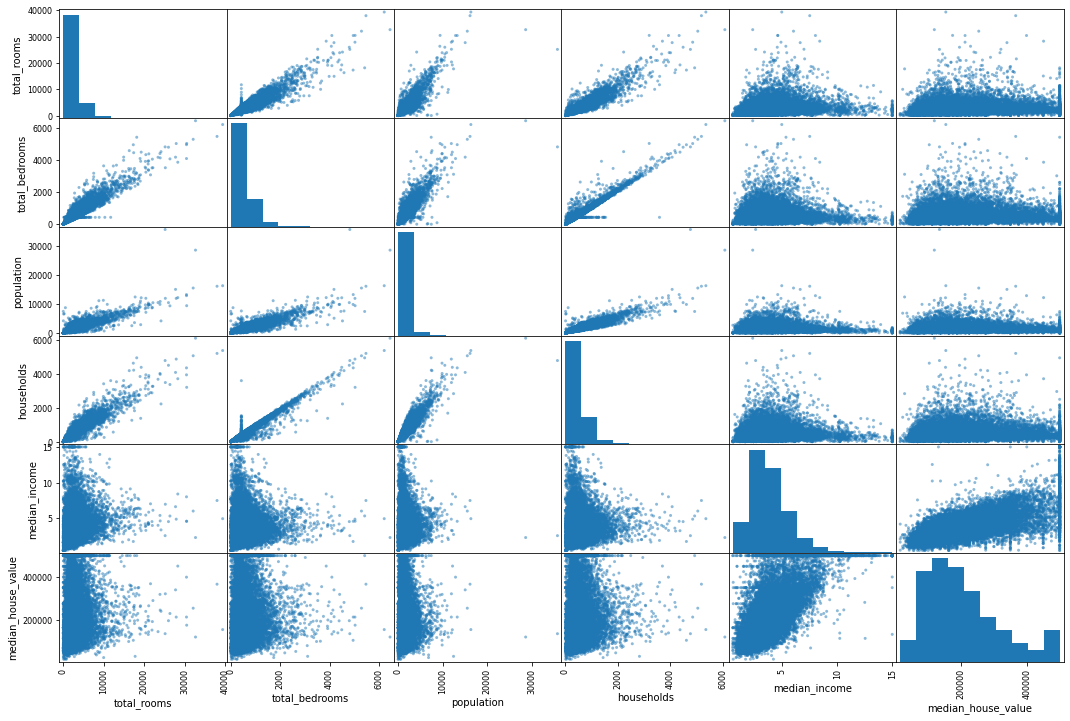

In [895]:
r = df_housing.select("total_rooms", "total_bedrooms", "population", "households", "median_income",
                      "median_house_value").toPandas()
ax = pd.plotting.scatter_matrix(r,figsize=(18, 12))

Прослеживается логичная прямая пропорциональная зависимость количества домовладений - с одной стороны и количеством комнат, спален, численностью населения - с другой.

Но для предсказания стоимости дома более важной является установление ее зависимости от других признаков. Для этого посчитаем корреляцию, переведя датасет с признаками в  Spark.

In [896]:
r = spark.createDataFrame(r)
r.printSchema()

root
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



Циклом пройдем по датасету функцией stat.corr(), построим график показателей корреляции целевого признака и признаков

In [897]:
for i in r.columns:
    print("Correlation to MHV for ", i, round((r.stat.corr('median_house_value',i)),2))

Correlation to MHV for  total_rooms 0.13
Correlation to MHV for  total_bedrooms 0.05


22/12/17 16:17:24 WARN TaskSetManager: Stage 1812 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1813 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1814 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1815 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.


Correlation to MHV for  population -0.02
Correlation to MHV for  households 0.07
Correlation to MHV for  median_income 0.69
Correlation to MHV for  median_house_value 1.0


22/12/17 16:17:25 WARN TaskSetManager: Stage 1816 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1817 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.


In [898]:
C1 = round((r.stat.corr('median_house_value','total_rooms')),2)
C2 = round((r.stat.corr('median_house_value','total_bedrooms')),2)
C3 = round((r.stat.corr('median_house_value','population')),2)
C4 = round((r.stat.corr('median_house_value','households')),2)
C5 = round((r.stat.corr('median_house_value','median_income')),2)

22/12/17 16:17:25 WARN TaskSetManager: Stage 1818 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1819 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1820 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1821 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 16:17:25 WARN TaskSetManager: Stage 1822 contains a task of very large size (1156 KiB). The maximum recommended task size is 1000 KiB.


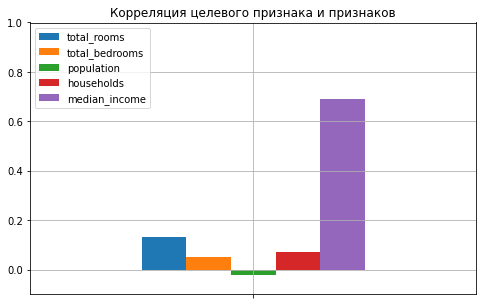

In [899]:
l = pd.DataFrame({'total_rooms': C1, 'total_bedrooms': C2,'population': C3, 'households': C4, 'median_income': C5,},
                 index = [''])
ax = l.plot.bar(ylim=(-0.1, 1), title='Корреляция целевого признака и признаков', figsize=(8, 5), grid=True,)

Наиболее высокая (0.69) положительная корреляция наблюдается между  медианной стоимостью жилого дома и медианным доходом жителей жилого массива. Зависимость стоимости жилья от таких признаков как количество комнат, спален и домовладений также положителная, но незначительная. Между численностью населения и стоимостью жилья отмечается невысокая, но обратная пропорция. 

## Обучение моделей

Выделяем признаки (отдельно категориальные и количественные) и целевой признак.

In [900]:
categorical_cols = ['ocean_proximity']
numerical_cols  = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
target = "median_house_value"

Разделим исходный датасет на обучающую и тестовую выборки в соотношении 4 : 1.

In [901]:
train_housing, test_housing = df_housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_housing.count(),test_housing.count())

16519 4121


### Обучение модели на всех признаках

Подготовим для обучения модели признаки обучающей выборки

Трансформируем категориальный признак 'ocean_proximity' с помощью трансформера StringIndexer

In [902]:
indexer = StringIndexer(inputCols=categorical_cols, outputCols= [c+'_idx' for c in categorical_cols])
train_housing = indexer.fit(train_housing).transform(train_housing)

Дополнительно применяем к нему OHE-кодирование с помощью OneHotEncoder.

In [903]:
encoder = OneHotEncoder(inputCols= [c+'_idx' for c in categorical_cols
                                   ], outputCols=[c+'_ohe' for c in categorical_cols])
train_housing = encoder.fit(train_housing).transform(train_housing)

Создадим вектор c категориальным признаком.

In [904]:
categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols
                                                  ], outputCol="categorical_features")

train_housing = categorical_assembler.transform(train_housing)

Создадим вектор количественных признаков и также их трансформируем.

In [905]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
train_housing = numerical_assembler.transform(train_housing)

scaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
train_housing = scaler.fit(train_housing).transform(train_housing)

Создадим вектор всех признаков, которые будем передавать модели для предсказаний целевого признака, и посмотрим на результат всех трансформаций.

In [906]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 
train_housing = final_assembler.transform(train_housing)

In [907]:
train_housing.printSchema()
train_housing.select('categorical_features','numerical_features_scaled', 'features').show(3) 

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- ocean_proximity_idx: double (nullable = false)
 |-- ocean_proximity_ohe: vector (nullable = true)
 |-- categorical_features: vector (nullable = true)
 |-- numerical_features: vector (nullable = true)
 |-- numerical_features_scaled: vector (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-------------------------+--------------------+
|categorical_features|numerical_features_scaled|            features|
+--------------------+-------------------------+--------------------+
|       (4,[2],[1.0])|     [4.13699

Аналогичный алгоритм трансформаций применим к тестовой выборке 

In [908]:
test_housing = indexer.fit(test_housing).transform(test_housing)

test_housing = encoder.fit(test_housing).transform(test_housing)

test_housing = categorical_assembler.transform(test_housing)

test_housing = numerical_assembler.transform(test_housing)

test_housing = scaler.fit(test_housing).transform(test_housing)

test_housing = final_assembler.transform(test_housing)

In [909]:
test_housing.printSchema()
test_housing.select('categorical_features','numerical_features_scaled', 'features').show(3)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- ocean_proximity_idx: double (nullable = false)
 |-- ocean_proximity_ohe: vector (nullable = true)
 |-- categorical_features: vector (nullable = true)
 |-- numerical_features: vector (nullable = true)
 |-- numerical_features_scaled: vector (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+-------------------------+--------------------+
|categorical_features|numerical_features_scaled|            features|
+--------------------+-------------------------+--------------------+
|       (4,[2],[1.0])|     [2.21403

Построим модель с использованием оценщика LinearRegression, передав ему вектор всех признаков 'features' и целевой признак 'median_house_value'. Выведем таблицу с целевым признаком и предсказаниями модели.

In [910]:
lr = LinearRegression(labelCol=target, featuresCol='features')

AllModel = lr.fit(train_housing) 

22/12/17 16:17:27 WARN Instrumentation: [6f941021] regParam is zero, which might cause numerical instability and overfitting.


In [911]:
predictionsAll = AllModel.transform(test_housing)
predictionsAll.select("median_house_value", "prediction").show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           78300.0| 176910.3931115353|
|           67000.0|178847.40572768525|
|           62500.0|193942.97375679715|
|          100600.0|221603.00523720618|
|          104200.0| 229561.9327908903|
+------------------+------------------+
only showing top 5 rows



Выводим метрики качества

In [912]:
A = round((RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(predictionsAll)),2)
B = round(RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(predictionsAll))
C = round(RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(predictionsAll))
print('R2: ', A)
print('RMSE: ', B)
print('MAE: ', C)

R2:  0.64
RMSE:  70309
MAE:  51738


### Обучение на количественных признаках

Создаем вектор количественных признаков 

In [913]:
numerical_assembler_num = VectorAssembler(inputCols= ("housing_median_age", "total_rooms", "total_bedrooms", 
                                    "population", "households", "median_income"), outputCol="NVfeatures") 

Стандартизируем данные на учебной выборке, трансформируем их и выводим результат трансформации количественных признаков

In [914]:
train_housing_num = numerical_assembler_num.transform(train_housing)

scaler = StandardScaler(inputCol='NVfeatures', outputCol="NVfeatures_scaled")
train_housing_num = scaler.fit(train_housing_num).transform(train_housing_num)

train_housing_num.select('NVfeatures_scaled').show(3) 

+--------------------+
|   NVfeatures_scaled|
+--------------------+
|[4.13699692929668...|
|[1.51159503185840...|
|[1.35247976534699...|
+--------------------+
only showing top 3 rows



Аналогичную трансформацию проделываем на тестовой выборке

In [915]:
test_housing_num = numerical_assembler_num.transform(test_housing)

test_housing_num = scaler.fit(test_housing_num).transform(test_housing_num)

test_housing_num.select('NVfeatures_scaled').show(3) 

+--------------------+
|   NVfeatures_scaled|
+--------------------+
|[2.21403010033479...|
|[2.68846512183511...|
|[4.11177018633605...|
+--------------------+
only showing top 3 rows



Обучаем модель на учебной выборке и получаем предсказания на тестовой

In [916]:
lrNum = LinearRegression(labelCol=target, featuresCol='NVfeatures_scaled')

NumModel = lrNum.fit(train_housing_num)

predictionsNum = NumModel.transform(test_housing_num)
predictionsNum.select("median_house_value", "prediction").show(5)

22/12/17 16:17:29 WARN Instrumentation: [fe06592a] regParam is zero, which might cause numerical instability and overfitting.


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           78300.0|133550.01116977754|
|           67000.0|136916.14967998682|
|           62500.0|162424.29447972262|
|          100600.0|179673.83394803246|
|          104200.0|195550.92712472443|
+------------------+------------------+
only showing top 5 rows



Выводим метрики качества

In [917]:
D = round((RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(predictionsNum)),2)
E = round(RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(predictionsNum))
F = round(RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(predictionsNum))
print('R2: ', D)
print('RMSE: ', E)
print('MAE: ', F)

R2:  0.56
RMSE:  76772
MAE:  57426


# Анализ результатов

Для анализа метрик качества моделей создадим датафрейм. 

In [918]:
df = spark.createDataFrame([('model_all', A, B, C),('model_numb', D, E, F)], ['model','R2','RMSE','MAE'])
df.printSchema()
df.show()

root
 |-- model: string (nullable = true)
 |-- R2: double (nullable = true)
 |-- RMSE: long (nullable = true)
 |-- MAE: long (nullable = true)

+----------+----+-----+-----+
|     model|  R2| RMSE|  MAE|
+----------+----+-----+-----+
| model_all|0.64|70309|51738|
|model_numb|0.56|76772|57426|
+----------+----+-----+-----+



Для оценки метрик не только между моделями, но и в сравнении с описательными статистиками целевого признака выведем их на экран. 

In [919]:
df_housing.select('median_house_value').describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             20640|
|   mean|206855.81690891474|
| stddev|115395.61587441359|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



Метрика для оценки качества модели регрессии RMSE (корень из среднеквадратичной ошибки) показывает насколько сильно правильный ответ отличается от предсказания, то есть, чем меньше значение, тем более предпочтительной является модель. RMSE model_all (70309) меньше RMSE model_numb (76772), значит по этому показателю приоритет у модели, построенной на всех признаках.

Значение MAE (среднее абсолютное отклонение значения предсказания от значения целевого признака) модели, построенной на всех признаках, ниже MAE модели, обученной только на количественных признаках (51738 и 57426 соответственно), что также говорит в пользу model_all.

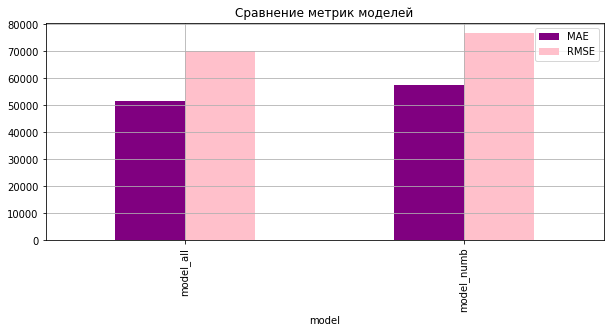

In [920]:
q = df.toPandas()[['model', 'RMSE', 'MAE']].pivot_table(index='model', values=['RMSE','MAE'])
ax = q.plot(grid=True, kind='bar', title='Сравнение метрик моделей', color = ['purple', 'pink'], figsize=(10, 4))

Кроме того, значения RMSE и MAE обеих моделей для данных целевого признака в диапазоне от 14999 до 500001 и mean=206856 смотрятся не такими уж большими, что свидетельствует об их жизнеспособности.

Метрика качества регрессии R2 (коэффициент детерминации), которая рассчитывается путем вычитания из единицы доли  среднеквадратичной ошибки модели от MSE среднего, в хорошей модели должна стремиться к 1. В наших моделях она выше у модели, обученной на всех признаках (0.64), что свидетельствует о ее более высоком качестве по сравнению с моделью model_numb (0.56)

# Финальный вывод

В соответствии с условием проекта мы построили две модели линейной регрессии, предсказывающие медианную стоимость дома в жилом массиве на данных о жилье в Калифорнии в 1990 году (https://www.kaggle.com/bhavinmoriya/introduction-to-pyspark/data). 

Целевым признаком для моделей избран "median_house_value". Данные, которые передавались моделям в качестве признаков, за исключением 1, содержали количественные значения. Из числа признаков были исключены "longitude", "latitude" и 
"housing_median_age" как не влияющие на формирование стоимости жилья.
  
Изучением зависимости признаков и целевого признака установлено, что наиболее высокая (0.69) положительная корреляция наблюдается между медианной стоимостью жилого дома и медианным доходом жителей жилого массива. Зависимость стоимости жилья от таких признаков как количество комнат, спален и домовладений также положителная, но незначительная. Между численностью населения и стоимостью жилья отмечается невысокая, но обратная пропорция.  

Для обучения моделей использован фреймворк Spark, посредством которого также были подготовлены данные: преобразован категориальный признак, в том числе техникой One hot encoding. Масштабированы численные данные, созданы векторы признаков, которые переданы оценщику.

Первая модель model_all обучена на категориальных и количественных признаках датафрейма, вторая модель model_numb - только на количественных.

Для оценки качества моделей применены метрики RMSE, MAE и R2.

Все метрики качества моделей говорят в пользу модели model_all, обученной на всех признаках (количественных и категориальных).  Метрики RMSE и MAE у данной модели ниже чем у model_numb, для построения которой передавался только вектор количественных признаков.

Кроме того, значения RMSE и MAE обеих моделей (68736 и 50037 соответственно для model_all и 75010 и 55802 для model_numb) для данных целевого признака в диапазоне от 14999 до 500001 и mean=206856 смотрятся не такими уж большими, что свидетельствует об их жизнеспособности.

Метрика качества регрессии R2, которая в хорошей модели должна стремиться к 1, также выше у модели, обученной на всех признаках (0.64), что свидетельствует о ее более высоком качестве по сравнению с моделью model_numb (0.57).

Таким образом, в качестве модели для предсказаний медианной стоимости дома в жилом массиве на данных о жилье в Калифорнии предлагается модель линейной регрессии model_all, обученная на количественных и категориальных признаках, имеющая наиболее лучшие метрики качества.